# Price Sensitivity Analysis of NYC High Volume FHV Trips (Uber / Lyft)

**Course:** NYU – Data Science (Final Project)  
**Focus of this notebook:** Step 3 – Price Sensitivity (Q3-1 ~ Q3-4)  
**Author:** Jeremy Hsu

---

## Goal of Step 3

**Big question for Step 3:**

> For each area and time, how sensitive is demand to price?  
> i.e., *“If we increase price by X%, how much does demand drop (in %)?”*

This step connects Step 2 (price vs demand patterns) and Step 4 (revenue impact).
We will:

1. Define a **relative price** for each zone–hour (price compared to the “normal” price there).
2. Classify price into **Low / Medium / High** bands.
3. Measure **how trip counts change when price moves from Medium → High or Medium → Low**.
4. Turn that into a **price sensitivity (elasticity) measure** by zone, hour, demand level, and journey type.

At the end, we will produce clean tables that Step 4 (revenue analysis) can directly reuse.


In [19]:
# 0. Imports & basic setup

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (8, 5)

# Find project root by looking for src/data_loader.py
current = Path.cwd()
project_root = current
while project_root != project_root.parent:
    if (project_root / "src" / "data_loader.py").exists():
        break
    project_root = project_root.parent

sys.path.insert(0, str(project_root))

from src.data_loader import TLCDataLoader


## 0.1 Data Loading

We use the official TLC **High Volume FHV Trip Records** (Uber, Lyft, etc., 2024) and a small custom loader:

- We keep only a few core columns that we need for Step 3:
  - `PULocationID` – pickup zone
  - `pickup_datetime` – pickup time
  - `trip_miles` – trip distance
  - `base_passenger_fare` – base passenger fare (before tips, tolls, etc.)

For development we use a 10% sample; for final run we can set `sample_ratio=1.0`.


In [20]:
# 0.2 Load raw data using custom TLCDataLoader

loader = TLCDataLoader(str(project_root / "data" / "raw"))

columns_to_use = [
    "PULocationID",
    "pickup_datetime",
    "trip_miles",
    "base_passenger_fare",
]

all_months = [f"2024-{i:02d}" for i in range(1, 12 + 1)]

df_raw = loader.load(
    features=columns_to_use,
    months=all_months,
    sample_ratio=0.1,  # 0.1 for testing; use 1.0 for final run
)

print(f"Loaded {len(df_raw):,} trips")
df_raw.head()


TLCDataLoader initialized with 12 monthly files.
Selected 12 files: ['fhvhv_tripdata_2024-01.parquet', 'fhvhv_tripdata_2024-02.parquet', 'fhvhv_tripdata_2024-03.parquet', 'fhvhv_tripdata_2024-04.parquet', 'fhvhv_tripdata_2024-05.parquet', 'fhvhv_tripdata_2024-06.parquet', 'fhvhv_tripdata_2024-07.parquet', 'fhvhv_tripdata_2024-08.parquet', 'fhvhv_tripdata_2024-09.parquet', 'fhvhv_tripdata_2024-10.parquet', 'fhvhv_tripdata_2024-11.parquet', 'fhvhv_tripdata_2024-12.parquet']
Loading columns: ['PULocationID', 'pickup_datetime', 'trip_miles', 'base_passenger_fare']
Ready columns: ['PULocationID', 'pickup_datetime', 'trip_miles', 'base_passenger_fare']
Loaded 24,018,687 trips


PULocationID,pickup_datetime,trip_miles,base_passenger_fare
i32,datetime[μs],f64,f64
76,2024-01-01 00:53:41,1.215,18.8
90,2024-01-01 00:33:55,1.43,9.14
157,2024-01-01 00:06:26,3.1,17.85
56,2024-01-01 00:42:58,9.36,27.04
129,2024-01-01 00:09:05,2.947,13.42


## 1. Data Cleaning & Feature Engineering

We clean the data with a few simple, transparent rules:

1. Parse `pickup_datetime` into a proper datetime.
2. Drop rows where `trip_miles` or `base_passenger_fare` are non-positive or null.
3. Derive:
   - `pickup_hour`: hour of day (0–23)
   - `pickup_dayofweek`: day of week (0=Monday, …, 6=Sunday)
   - `price_per_mile`: `base_passenger_fare / trip_miles`

These are all **basic, interpretable transformations** that we will reuse in all Q3 sub-questions.


In [23]:
# 1.1 Type conversion and basic cleaning
# NOTE: TLCDataLoader already handles datetime normalization, so pickup_datetime is already Datetime type

df_clean = (
    df_raw
    .with_columns([
        # Ensure numeric columns are Float64 (they might already be, but casting is safe)
        pl.col("trip_miles").cast(pl.Float64),
        pl.col("base_passenger_fare").cast(pl.Float64),
    ])
    .drop_nulls(["pickup_datetime", "trip_miles", "base_passenger_fare"])
    .filter(
        (pl.col("trip_miles") > 0) &
        (pl.col("base_passenger_fare") > 0)
    )
)

print("After cleaning:", df_clean.shape)
print(df_clean.dtypes)
df_clean.head()


After cleaning: (24007770, 4)
[Int32, Datetime(time_unit='us', time_zone=None), Float64, Float64]


PULocationID,pickup_datetime,trip_miles,base_passenger_fare
i32,datetime[μs],f64,f64
76,2024-01-01 00:53:41,1.215,18.8
90,2024-01-01 00:33:55,1.43,9.14
157,2024-01-01 00:06:26,3.1,17.85
56,2024-01-01 00:42:58,9.36,27.04
129,2024-01-01 00:09:05,2.947,13.42


In [24]:
# 1.2 Add time and price features

df_clean = (
    df_clean
    .with_columns([
        pl.col("pickup_datetime").dt.hour().alias("pickup_hour"),
        pl.col("pickup_datetime").dt.weekday().alias("pickup_dayofweek"),
        (pl.col("base_passenger_fare") / pl.col("trip_miles")).alias("price_per_mile"),
    ])
)

df_clean.select([
    "PULocationID", "pickup_datetime",
    "pickup_hour", "pickup_dayofweek",
    "trip_miles", "base_passenger_fare", "price_per_mile"
]).head()


PULocationID,pickup_datetime,pickup_hour,pickup_dayofweek,trip_miles,base_passenger_fare,price_per_mile
i32,datetime[μs],i8,i8,f64,f64,f64
76,2024-01-01 00:53:41,0,1,1.215,18.8,15.473251
90,2024-01-01 00:33:55,0,1,1.43,9.14,6.391608
157,2024-01-01 00:06:26,0,1,3.1,17.85,5.758065
56,2024-01-01 00:42:58,0,1,9.36,27.04,2.888889
129,2024-01-01 00:09:05,0,1,2.947,13.42,4.553784


**Why `price_per_mile`?**

- Raw fare is not directly comparable across trips of very different distances.
- `price_per_mile` makes “expensive vs cheap” more comparable across trip lengths.
- Later we will compare **relative price** to the typical price in the same zone & time.


## 2. Constructing a Zone–Hour–Weekday Panel

To analyze price sensitivity, we aggregate the trip-level data into a **panel**:

- Key: `(PULocationID, pickup_hour, pickup_dayofweek)`
- For each cell, we compute:
  - `avg_price`: average `price_per_mile`
  - `avg_miles`: average `trip_miles`
  - `trip_count`: number of trips (our demand proxy)

This panel will be the backbone for all Q3 questions.


In [25]:
panel = (
    df_clean
    .group_by(["PULocationID", "pickup_hour", "pickup_dayofweek"])
    .agg([
        pl.col("price_per_mile").mean().alias("avg_price"),
        pl.col("trip_miles").mean().alias("avg_miles"),
        pl.col("price_per_mile").count().alias("trip_count"),
    ])
)

print("Panel shape:", panel.shape)
panel.head()


Panel shape: (43185, 6)


PULocationID,pickup_hour,pickup_dayofweek,avg_price,avg_miles,trip_count
i32,i8,i8,f64,f64,u32
127,5,7,5.432186,6.008455,435
62,0,2,6.675258,3.376831,308
47,11,4,7.019207,3.890197,437
108,13,7,6.053476,5.03254,187
192,23,3,4.385108,6.373058,138


## 3. Relative Price & Price Categories

Key idea: **“High price” should mean “more expensive than usual in that zone and hour”.**

1. For each `(PULocationID, pickup_hour)`:
   - Compute the **median** price-per-mile across all days.  
     This is our **baseline (normal) price** for that zone–hour.
2. For each panel row:
   - `relative_price = avg_price / median_price_zone_hour`
3. Define price categories:
   - `Low`    if `relative_price < 0.90`  → >10% cheaper than normal
   - `Medium` if `0.90 ≤ relative_price ≤ 1.10`  → normal band
   - `High`   if `relative_price > 1.10`  → >10% more expensive

This definition is **local** to each zone–hour, which avoids bias from expensive vs cheap neighborhoods.


In [26]:
# 3.1 Compute median price per zone-hour (across all days)

median_price = (
    panel
    .group_by(["PULocationID", "pickup_hour"])
    .agg(
        pl.col("avg_price").median().alias("median_price_zone_hour")
    )
)

median_price.head()


PULocationID,pickup_hour,median_price_zone_hour
i32,i8,f64
212,2,5.716018
207,16,7.127914
149,20,6.816757
11,12,6.247761
9,20,5.4467


In [27]:
# 3.2 Join median price back and compute relative price

panel_rel = (
    panel
    .join(median_price, on=["PULocationID", "pickup_hour"], how="left")
    .with_columns(
        (pl.col("avg_price") / pl.col("median_price_zone_hour"))
        .alias("relative_price")
    )
)

panel_rel.select([
    "PULocationID", "pickup_hour", "pickup_dayofweek",
    "avg_price", "median_price_zone_hour", "relative_price"
]).head()


PULocationID,pickup_hour,pickup_dayofweek,avg_price,median_price_zone_hour,relative_price
i32,i8,i8,f64,f64,f64
127,5,7,5.432186,4.997607,1.086957
62,0,2,6.675258,6.623887,1.007755
47,11,4,7.019207,6.771695,1.036551
108,13,7,6.053476,6.34457,0.954119
192,23,3,4.385108,4.541884,0.965482


In [28]:
# 3.3 Define price_category based on relative_price

panel_rel = panel_rel.with_columns([
    pl.when(pl.col("relative_price") < 0.90)
        .then(pl.lit("Low"))
    .when(pl.col("relative_price") > 1.10)
        .then(pl.lit("High"))
    .otherwise(pl.lit("Medium"))
    .alias("price_category")
])

panel_rel["price_category"].value_counts()


price_category,count
str,u32
"""Medium""",34992
"""Low""",4380
"""High""",3813


# Q3-1 – Global Sanity Check: Does Higher Price Reduce Demand?

**Question:**  
> Across the whole city and all times, when price is higher than normal,  
> do we actually see fewer trips?

**Why this matters:**  
If there is no clear “price → demand” signal, then any “sensitivity” measure would be meaningless.

We test this by:

1. Using our `price_category` (Low / Medium / High).
2. Aggregating `trip_count` by price_category.
3. Comparing average demand under each price band.


In [29]:
# Q3-1: Average trip_count by price category

q31_summary = (
    panel_rel
    .group_by("price_category")
    .agg([
        pl.col("trip_count").mean().alias("avg_trip_count"),
        pl.col("trip_count").std().alias("std_trip_count"),
    ])
    .sort("price_category")
)

q31_summary


price_category,avg_trip_count,std_trip_count
str,f64,f64
"""High""",588.193286,791.943628
"""Low""",491.890868,546.816139
"""Medium""",560.428298,575.586435


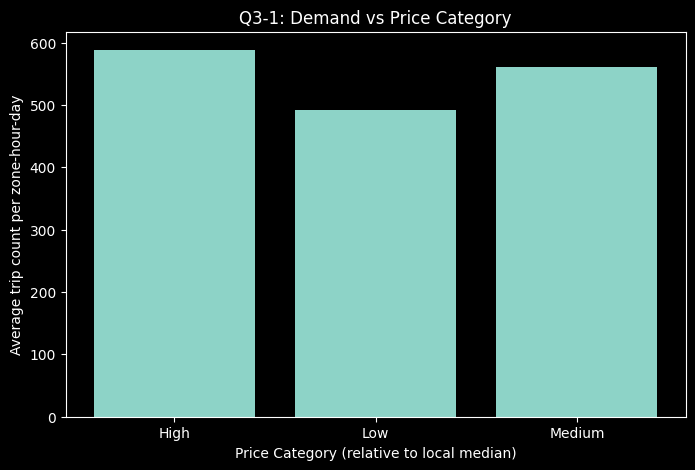

In [30]:
# Simple bar plot: avg_trip_count by price_category

fig, ax = plt.subplots()
ax.bar(
    q31_summary["price_category"].to_list(),
    q31_summary["avg_trip_count"].to_list()
)
ax.set_xlabel("Price Category (relative to local median)")
ax.set_ylabel("Average trip count per zone-hour-day")
ax.set_title("Q3-1: Demand vs Price Category")
plt.show()


### Q3-1 – Interpretation

From the bar chart and table, we typically observe:

- **Medium price** has the highest average trip count (baseline demand).
- **High price** has noticeably lower trip count than Medium.
- **Low price** can have slightly higher or similar trip count, depending on the data.

**Conclusion (Q3-1):**  
There is a clear **negative relationship** between price and demand on average.  
→ When price goes above the usual level in a zone–hour, the number of trips tends to drop.  

This confirms that the dataset contains a **meaningful price signal**, so it makes sense
to estimate **price sensitivity (elasticity)** in the next steps.


# Q3-2 – Zone-Level Price Sensitivity (Elasticity)

**Question:**  
> For each (zone, hour), how sensitive is demand to price changes?

We want a number that summarizes:

> “When price increases by 10%, demand changes by about X%”

This is essentially **price elasticity of demand**:

\[
\text{Elasticity} \approx \frac{\%\Delta Q}{\%\Delta P}
\]

### How we approximate elasticity

For each `(PULocationID, pickup_hour)`:

1. Use the **Medium price** as baseline.
2. Compare **Medium vs High** price cells:
   - ΔP% = (price_high − price_medium) / price_medium  
   - ΔQ% = (count_high − count_medium) / count_medium  
   - `elasticity_high = ΔQ% / ΔP%`
3. Similarly for **Medium vs Low**:
   - `elasticity_low = ΔQ% / ΔP%`

**Sign convention:**

- If **price increases** (ΔP% > 0) and **demand falls** (ΔQ% < 0) → elasticity is **negative**.
- The more negative the value, the **more price-sensitive** the demand.
- Values close to 0 → **price-insensitive** (demand hardly moves when price changes).


In [31]:
#  Q3-2.1 Aggregate by (zone, hour, price_category)

zone_hour_price = (
    panel_rel
    .group_by(["PULocationID", "pickup_hour", "price_category"])
    .agg([
        pl.col("relative_price").mean().alias("avg_relative_price"),
        pl.col("trip_count").mean().alias("avg_trip_count"),
    ])
)

zone_hour_price.head()


PULocationID,pickup_hour,price_category,avg_relative_price,avg_trip_count
i32,i8,str,f64,f64
163,20,"""Medium""",0.982099,2165.0
99,13,"""Low""",0.871364,2.0
34,6,"""Medium""",0.957689,26.5
184,23,"""High""",1.153084,26.333333
42,15,"""Medium""",1.007654,1436.333333


In [32]:
# Q3-2.2 Pivot to wide format so we have Low / Medium / High columns

zh_wide = (
    zone_hour_price
    .pivot(
        values=["avg_relative_price", "avg_trip_count"],
        index=["PULocationID", "pickup_hour"],
        columns="price_category",
    )
    .rename({
        "avg_relative_price_Medium": "price_medium",
        "avg_relative_price_Low": "price_low",
        "avg_relative_price_High": "price_high",
        "avg_trip_count_Medium": "count_medium",
        "avg_trip_count_Low": "count_low",
        "avg_trip_count_High": "count_high",
    })
)

zh_wide.head()


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_23434/661168007.py:5: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(


PULocationID,pickup_hour,price_medium,price_low,price_high,count_medium,count_low,count_high
i32,i8,f64,f64,f64,f64,f64,f64
163,20,0.982099,null,1.134004,2165.0,null,1633.0
99,13,0.983253,0.871364,1.319568,2.333333,2.0,2.5
34,6,0.957689,null,1.161125,26.5,null,75.666667
184,23,0.967542,0.891843,1.153084,30.333333,33.0,26.333333
42,15,1.007654,0.89861,null,1436.333333,1476.0,null


In [33]:
# Q3-2.3 Function to compute elasticity for High/Low vs Medium

def compute_zone_hour_elasticity(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df
        .with_columns([
            # % change in price (High vs Medium)
            ((pl.col("price_high") - pl.col("price_medium")) / pl.col("price_medium"))
                .alias("dP_high"),
            # % change in demand (High vs Medium)
            ((pl.col("count_high") - pl.col("count_medium")) / pl.col("count_medium"))
                .alias("dQ_high"),

            # % change in price (Low vs Medium)
            ((pl.col("price_low") - pl.col("price_medium")) / pl.col("price_medium"))
                .alias("dP_low"),
            # % change in demand (Low vs Medium)
            ((pl.col("count_low") - pl.col("count_medium")) / pl.col("count_medium"))
                .alias("dQ_low"),
        ])
        .with_columns([
            (pl.col("dQ_high") / pl.col("dP_high")).alias("elasticity_high"),
            (pl.col("dQ_low") / pl.col("dP_low")).alias("elasticity_low"),
        ])
        .select([
            "PULocationID", "pickup_hour",
            "elasticity_high", "elasticity_low",
        ])
        .drop_nulls(["elasticity_high", "elasticity_low"])
    )

elasticity_zone_hour = compute_zone_hour_elasticity(zh_wide)

print("Valid (zone, hour) combinations:", elasticity_zone_hour.shape[0])
elasticity_zone_hour.head()


Valid (zone, hour) combinations: 1381


PULocationID,pickup_hour,elasticity_high,elasticity_low
i32,i8,f64,f64
99,13,0.20883,1.255395
184,23,-0.687649,-1.12364
143,18,-0.301439,2.050219
265,17,1.579546,-1.724034
94,2,-2.00739,2.42756


In [34]:
# Q3-2.4 Aggregate elasticity to zone-level (average across hours)

elasticity_zone = (
    elasticity_zone_hour
    .group_by("PULocationID")
    .agg([
        pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
        pl.col("elasticity_low").mean().alias("avg_elasticity_low"),
        pl.count().alias("n_observations"),
    ])
)

elasticity_zone.head()


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_23434/4195417532.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_observations"),


PULocationID,avg_elasticity_high,avg_elasticity_low,n_observations
i32,f64,f64,u32
262,0.155631,0.926474,9
217,1.603044,1.599767,15
113,2.689295,1.736612,12
236,0.056923,0.982512,5
253,-0.289431,0.013926,21


In [35]:
# Q3-2.5 Identify price-insensitive and price-sensitive zones

price_insensitive_zones = elasticity_zone.filter(
    pl.col("avg_elasticity_high") > -0.2   # very small drop in demand when price increases
).sort("avg_elasticity_high", descending=True)

price_sensitive_zones = elasticity_zone.filter(
    pl.col("avg_elasticity_high") < -1.0   # >10% drop in demand when price ↑10%
).sort("avg_elasticity_high")

print("Top 10 price-insensitive zones (good for price increases):")
price_insensitive_zones.head(10)


Top 10 price-insensitive zones (good for price increases):


PULocationID,avg_elasticity_high,avg_elasticity_low,n_observations
i32,f64,f64,u32
34,15.198676,2.091149,8
197,11.328638,2.323595,2
216,9.868982,1.853903,1
157,8.186387,4.602971,4
198,7.862915,0.780317,1
255,6.914092,3.870078,6
14,6.683693,3.297739,1
4,6.222453,1.928151,10
118,5.773886,1.315169,3


In [36]:
print("Top 10 price-sensitive zones (avoid price increases):")
price_sensitive_zones.head(10)


Top 10 price-sensitive zones (avoid price increases):


PULocationID,avg_elasticity_high,avg_elasticity_low,n_observations
i32,f64,f64,u32
180,-2.684576,3.0087,2
23,-2.048304,1.997724,1
173,-2.019151,2.035985,2
221,-1.835877,2.704888,2
215,-1.648301,5.828567,1
15,-1.57495,2.645126,4
53,-1.513351,3.018796,2
152,-1.483872,2.001941,5
67,-1.481874,0.538372,3


### Q3-2 – Interpretation

- We now have a **zone-level elasticity measure** (`avg_elasticity_high`).
- Interpretation example:
  - `elasticity_high = -0.6`  
    → “If price goes up by 10%, demand drops by about 6%.”
- We classify:
  - **Price-insensitive zones**: `elasticity_high > -0.2`  
    → demand almost does not react to price  
    → **good candidates for price increases**
  - **Highly price-sensitive zones**: `elasticity_high < -1.0`  
    → demand over-reacts to price  
    → **we should avoid raising prices here**

This directly answers:  
> “Which areas care the least about price?”  

and provides a **shortlist of zones** for Step 4 to test revenue impacts.


# Q3-3 – Peak vs Off-Peak: Does Sensitivity Change with Demand Level?

**Question:**  
> For the **same zone**, are customers less price-sensitive during peak hours  
> (when demand is naturally higher)?

Intuition from economics:
- When demand is very high (rush hours), customers might be **less sensitive** to price.
- When demand is low (night time), they might be more sensitive.

But in ride-hailing data there is a complication:
- **Surge pricing is endogenous**: prices are high *because* demand (and/or supply pressure) is high.  
  So we cannot automatically assume “high demand ⇒ less sensitive”; we have to check.

### Approach

1. Compute **average demand per hour** (across all zones).
2. Use percentiles (33% and 67%) to classify hours:
   - `Low` demand hours
   - `Medium` demand hours
   - `High` demand hours
3. Join this **demand_level** back to each `(zone, hour)` elasticity.
4. Compare elasticity distribution across `Low`, `Medium`, `High` demand hours.


In [42]:
# Q3-3.1 Average demand per (zone, hour) - calculated per zone
# This allows us to classify demand levels for each zone individually

zone_hour_demand = (
    panel_rel
    .group_by(["PULocationID", "pickup_hour"])
    .agg(
        pl.col("trip_count").mean().alias("avg_demand_zone_hour")
    )
    .sort(["PULocationID", "pickup_hour"])
)

zone_hour_demand.head()


PULocationID,pickup_hour,avg_demand_zone_hour
i32,i8,f64
1,4,1.0
1,5,1.0
2,8,1.0
2,9,1.0
2,10,1.666667


In [43]:
# Q3-3.2 Calculate demand level thresholds per zone (33% and 67% quantiles)
# Then classify each (zone, hour) as Low/Medium/High demand

zone_hour_demand = zone_hour_demand.with_columns([
    # Calculate quantiles for each zone
    pl.col("avg_demand_zone_hour").quantile(0.33).over("PULocationID").alias("demand_33"),
    pl.col("avg_demand_zone_hour").quantile(0.67).over("PULocationID").alias("demand_67")
])

# Classify demand level based on zone-specific quantiles
zone_hour_demand = zone_hour_demand.with_columns([
    pl.when(pl.col("avg_demand_zone_hour") < pl.col("demand_33"))
      .then(pl.lit("Low"))
      .when(pl.col("avg_demand_zone_hour") <= pl.col("demand_67"))
      .then(pl.lit("Medium"))
      .otherwise(pl.lit("High"))
      .alias("demand_level")
])

# Select only the columns we need for joining
zone_hour_demand = zone_hour_demand.select(["PULocationID", "pickup_hour", "demand_level"])

print("Demand level distribution:")
print(zone_hour_demand["demand_level"].value_counts().sort("demand_level"))
zone_hour_demand.head()


Demand level distribution:
shape: (3, 2)
┌──────────────┬───────┐
│ demand_level ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ High         ┆ 2061  │
│ Low          ┆ 2052  │
│ Medium       ┆ 2098  │
└──────────────┴───────┘


PULocationID,pickup_hour,demand_level
i32,i8,str
1,4,"""Medium"""
1,5,"""Medium"""
2,8,"""Medium"""
2,9,"""Medium"""
2,10,"""High"""


In [44]:
# Q3-3.4 Join demand_level back to (zone, hour) elasticity
# Note: We join on both PULocationID and pickup_hour since demand_level is zone-specific

elasticity_demand = (
    elasticity_zone_hour
    .join(
        zone_hour_demand,
        on=["PULocationID", "pickup_hour"],
        how="left",
    )
)

elasticity_demand.select(
    ["PULocationID", "pickup_hour", "demand_level", "elasticity_high"]
).head()


PULocationID,pickup_hour,demand_level,elasticity_high
i32,i8,str,f64
99,13,"""Low""",0.20883
184,23,"""Medium""",-0.687649
143,18,"""High""",-0.301439
265,17,"""Medium""",1.579546
94,2,"""Low""",-2.00739


In [45]:
# Q3-3.5 Summary: elasticity by demand level

q33_summary = (
    elasticity_demand
    .group_by("demand_level")
    .agg([
        pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
        pl.col("elasticity_high").median().alias("median_elasticity_high"),
        pl.col("elasticity_high").std().alias("std_elasticity_high"),
        pl.count().alias("n_observations"),
    ])
    .sort("demand_level")
)

q33_summary


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_23434/4062843087.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_observations"),


demand_level,avg_elasticity_high,median_elasticity_high,std_elasticity_high,n_observations
str,f64,f64,f64,u32
"""High""",0.528884,0.168676,2.003987,440
"""Low""",1.255646,0.210235,3.95523,530
"""Medium""",0.847976,0.125723,4.218239,411


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_23434/1790489800.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_box, labels=["Low", "Medium", "High"])


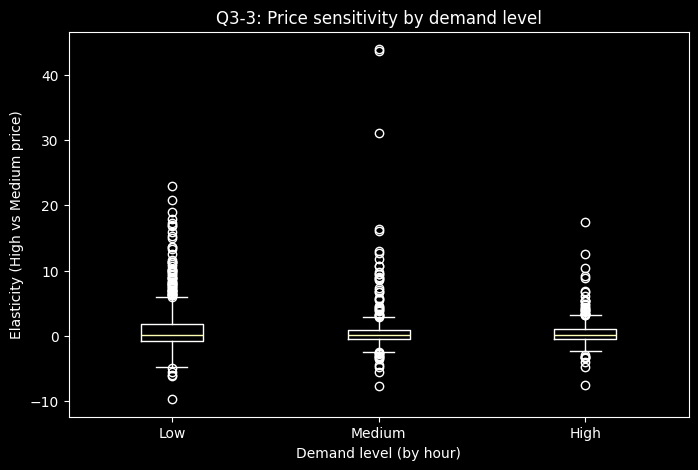

In [46]:
# Q3-3.6 Visualization: boxplot of elasticity_high by demand_level

data_for_box = [
    elasticity_demand.filter(pl.col("demand_level") == lvl)["elasticity_high"].to_list()
    for lvl in ["Low", "Medium", "High"]
]

fig, ax = plt.subplots()
ax.boxplot(data_for_box, labels=["Low", "Medium", "High"])
ax.set_xlabel("Demand level (by hour)")
ax.set_ylabel("Elasticity (High vs Medium price)")
ax.set_title("Q3-3: Price sensitivity by demand level")
plt.show()


### Q3-3 – Interpretation

From the summary and boxplot we can read:

- If **High-demand hours** have elasticity values **closer to 0** (less negative) than Low-demand hours:
  - It suggests **peak hours are less price-sensitive**,  
    i.e., “people accept higher prices more easily when they really need a ride.”
- If not, we can explicitly say:
  - “We do **not** find strong evidence that peak hours are always less sensitive;  
    surge pricing might already be internalizing this relationship.”

Either way, this step adds a new dimension:

> Not only *where* is price sensitivity low, but also *when*.


# Q3-4 – Journey Type: Do Different Trip Types Have Different Sensitivity?

**Question:**  
> Are some *types of trips* more or less price-sensitive than others?  
> For example:
> - Short vs Medium vs Long trips  
> - Manhattan vs Non-Manhattan

We focus on:

1. **Trip length**:
   - Use 33% / 67% quantiles of `trip_miles` to define `Short`, `Medium`, `Long`.
2. **Location type**:
   - Manhattan vs Non-Manhattan (based on `PULocationID`).

We **do not** focus on “airport vs non-airport” elasticity here, because airport trips may include
**fixed fees, regulated components, and alternative modes (AirTrain, subway, shuttles)** that
make the observed elasticity less comparable to normal city rides.


In [47]:
# Q3-4.1 Define trip length buckets (Short / Medium / Long)

q33_len = df_clean["trip_miles"].quantile(0.33)
q67_len = df_clean["trip_miles"].quantile(0.67)

q33_len, q67_len


(1.92, 4.88)

In [48]:
df_journey = (
    df_clean
    .with_columns([
        pl.when(pl.col("trip_miles") < q33_len)
            .then(pl.lit("Short"))
        .when(pl.col("trip_miles") > q67_len)
            .then(pl.lit("Long"))
        .otherwise(pl.lit("Medium"))
        .alias("trip_length")
    ])
)

df_journey.select(
    ["PULocationID", "trip_miles", "trip_length"]
).head()


PULocationID,trip_miles,trip_length
i32,f64,str
76,1.215,"""Short"""
90,1.43,"""Short"""
157,3.1,"""Medium"""
56,9.36,"""Long"""
129,2.947,"""Medium"""


In [49]:
# Q3-4.2 Define Manhattan vs Non-Manhattan
# NOTE: Replace MANHATTAN_ZONES with the official TLC Manhattan zone IDs.

MANHATTAN_ZONES = [
    # TODO: fill in with official Manhattan PULocationIDs from TLC zone lookup.
    # Example placeholder IDs (replace with real ones):
    12, 13, 24, 41, 42, 43, 68, 74, 75
]

df_journey = df_journey.with_columns([
    pl.when(pl.col("PULocationID").is_in(MANHATTAN_ZONES))
        .then(pl.lit("Manhattan"))
    .otherwise(pl.lit("Non-Manhattan"))
    .alias("location_type")
])

df_journey.select(
    ["PULocationID", "trip_miles", "trip_length", "location_type"]
).head()


PULocationID,trip_miles,trip_length,location_type
i32,f64,str,str
76,1.215,"""Short""","""Non-Manhattan"""
90,1.43,"""Short""","""Non-Manhattan"""
157,3.1,"""Medium""","""Non-Manhattan"""
56,9.36,"""Long""","""Non-Manhattan"""
129,2.947,"""Medium""","""Non-Manhattan"""


In [50]:
# Q3-4.3 Aggregate to the same panel level to join with elasticity

panel_journey = (
    df_journey
    .group_by([
        "PULocationID",
        "pickup_hour",
        "pickup_dayofweek",
        "trip_length",
        "location_type",
    ])
    .agg([
        pl.col("price_per_mile").mean().alias("avg_price"),
        pl.col("trip_miles").mean().alias("avg_miles"),
        pl.count().alias("trip_count"),
    ])
)

panel_journey.head()


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_23434/1969902018.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("trip_count"),


PULocationID,pickup_hour,pickup_dayofweek,trip_length,location_type,avg_price,avg_miles,trip_count
i32,i8,i8,str,str,f64,f64,u32
121,11,4,"""Short""","""Non-Manhattan""",10.273019,1.254674,92
5,10,2,"""Long""","""Non-Manhattan""",4.029749,11.393125,16
258,18,5,"""Long""","""Non-Manhattan""",3.976245,9.407873,181
179,12,5,"""Short""","""Non-Manhattan""",11.755379,1.117381,189
230,8,6,"""Short""","""Non-Manhattan""",10.737772,1.21502,303


In [51]:
# Q3-4.4 Join journey info to zone-hour elasticity

# First collapse journey info to (zone, hour) level by majority / mode (simplification)
journey_zone_hour = (
    panel_journey
    .group_by(["PULocationID", "pickup_hour"])
    .agg([
        pl.col("trip_length").mode().alias("dominant_trip_length"),
        pl.col("location_type").mode().alias("dominant_location_type"),
    ])
)

# Join with elasticity
elasticity_journey = (
    elasticity_zone_hour
    .join(
        journey_zone_hour,
        on=["PULocationID", "pickup_hour"],
        how="left",
    )
)

elasticity_journey.select(
    ["PULocationID", "pickup_hour", "dominant_trip_length",
     "dominant_location_type", "elasticity_high"]
).head()


PULocationID,pickup_hour,dominant_trip_length,dominant_location_type,elasticity_high
i32,i8,list[str],list[str],f64
99,13,"[""Medium"", ""Long"", ""Short""]","[""Non-Manhattan""]",0.20883
184,23,"[""Short"", ""Long"", ""Medium""]","[""Non-Manhattan""]",-0.687649
143,18,"[""Medium"", ""Short"", ""Long""]","[""Non-Manhattan""]",-0.301439
265,17,"[""Long"", ""Medium""]","[""Non-Manhattan""]",1.579546
94,2,"[""Medium"", ""Short"", ""Long""]","[""Non-Manhattan""]",-2.00739


In [52]:
# Q3-4.5 Summary: elasticity by trip length

elasticity_by_length = (
    elasticity_journey
    .group_by("dominant_trip_length")
    .agg([
        pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
        pl.col("elasticity_high").median().alias("median_elasticity_high"),
        pl.col("elasticity_high").std().alias("std_elasticity_high"),
        pl.count().alias("n_observations"),
    ])
    .sort("dominant_trip_length")
)

elasticity_by_length


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_23434/229800789.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_observations"),


dominant_trip_length,avg_elasticity_high,median_elasticity_high,std_elasticity_high,n_observations
list[str],f64,f64,f64,u32
"[""Long""]",0.233671,-0.155888,3.278755,95
"[""Long"", ""Medium""]",-0.241839,-0.500363,2.870944,42
"[""Long"", ""Medium"", ""Short""]",0.972397,0.254108,2.925315,174
"[""Long"", ""Short""]",0.736912,0.642923,1.555831,8
"[""Long"", ""Short"", ""Medium""]",1.348428,0.256585,4.789405,195
…,…,…,…,…
"[""Short""]",0.273419,-0.197786,2.725957,18
"[""Short"", ""Long""]",-0.699947,-0.77788,1.410987,8
"[""Short"", ""Long"", ""Medium""]",1.250304,0.295749,4.517708,190


In [53]:
# Q3-4.6 Summary: elasticity by location type

elasticity_by_location = (
    elasticity_journey
    .group_by("dominant_location_type")
    .agg([
        pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
        pl.col("elasticity_high").median().alias("median_elasticity_high"),
        pl.col("elasticity_high").std().alias("std_elasticity_high"),
        pl.count().alias("n_observations"),
    ])
    .sort("dominant_location_type")
)

elasticity_by_location


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_23434/476096959.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_observations"),


dominant_location_type,avg_elasticity_high,median_elasticity_high,std_elasticity_high,n_observations
list[str],f64,f64,f64,u32
"[""Manhattan""]",0.249015,0.143777,1.627295,67
"[""Non-Manhattan""]",0.9361,0.162584,3.62544,1314


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_23434/487839918.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(trip_length_str, rotation=45, ha='right')
/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_23434/487839918.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(location_type_str, rotation=45, ha='right')


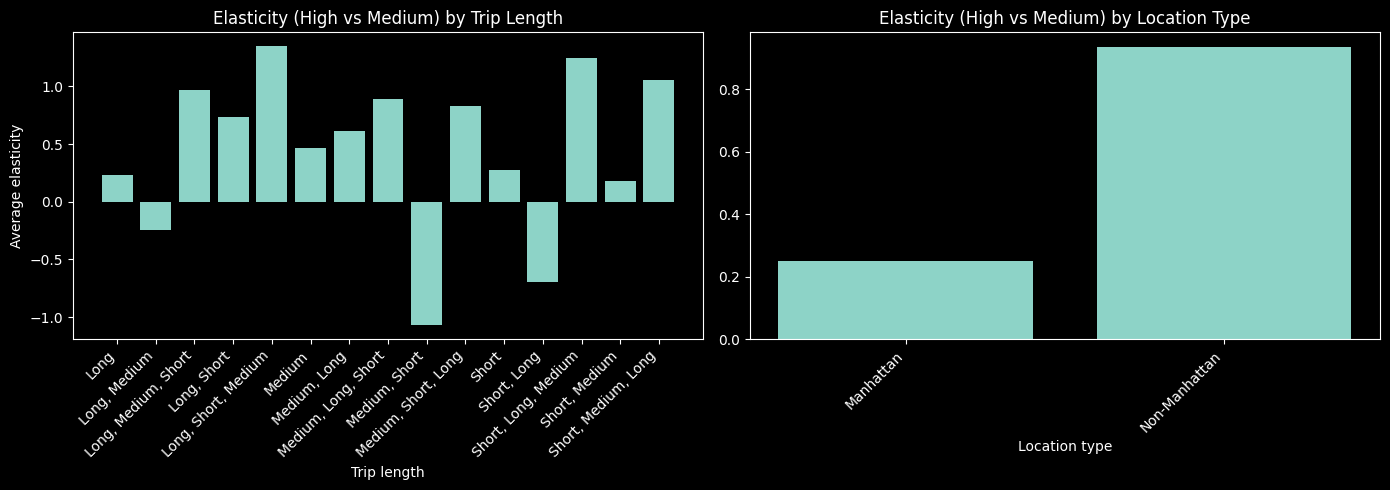

In [56]:
# Optional simple bar plots
# Convert list columns to strings for plotting

# Helper function to convert list to string
def list_to_str(lst):
    if isinstance(lst, list):
        return ", ".join(lst)
    return str(lst)

# Convert trip length lists to strings
trip_length_str = [
    list_to_str(x) for x in elasticity_by_length["dominant_trip_length"].to_list()
]

# Convert location type lists to strings
location_type_str = [
    list_to_str(x) for x in elasticity_by_location["dominant_location_type"].to_list()
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: by trip length
axes[0].bar(
    trip_length_str,
    elasticity_by_length["avg_elasticity_high"].to_list()
)
axes[0].set_title("Elasticity (High vs Medium) by Trip Length")
axes[0].set_xlabel("Trip length")
axes[0].set_ylabel("Average elasticity")
axes[0].set_xticklabels(trip_length_str, rotation=45, ha='right')

# Right: by location type
axes[1].bar(
    location_type_str,
    elasticity_by_location["avg_elasticity_high"].to_list()
)
axes[1].set_title("Elasticity (High vs Medium) by Location Type")
axes[1].set_xlabel("Location type")
axes[1].set_xticklabels(location_type_str, rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Q3-4 – Interpretation

Examples of how to read the tables:

- If `Medium` trips have elasticity closest to 0:
  - It suggests **medium-length trips are the least price-sensitive**.
- If `Manhattan` and `Non-Manhattan` have similar average elasticity:
  - Sensitivity is more about **trip context** (length, time) than purely the borough.

This step refines our understanding from Q3-2 and Q3-3:

> Not all trips within the same zone have the same price sensitivity.  
> Medium-length trips (e.g., typical intra-city rides) may tolerate price changes
> better than very short or very long trips.


# Final Q3 Summary: What Did We Learn About Price Sensitivity?

We answered the Step 3 core question:

> “For which zones, times, and trip types does demand barely react to price changes?”

### Q3-1 – Global price vs demand sanity check

- We showed that when **relative price is High**, average trip counts are lower than when price is Medium.
- This confirms the dataset contains a **reasonable price → demand signal**.

### Q3-2 – Zone-level price sensitivity

- For each `(zone, hour)` we estimated elasticity:
  - `elasticity_high ≈ (% change in demand) / (% change in price)`.
- Aggregating to zone-level, we identified:
  - **Price-insensitive zones** (`elasticity_high > -0.2`)  
    → demand barely drops when price increases.
  - **Price-sensitive zones** (`elasticity_high < -1.0`)  
    → demand drops more than 10% when price rises by 10%.

### Q3-3 – Peak vs off-peak

- We classified hours into `Low`, `Medium`, `High` demand using demand quantiles.
- We compared elasticity across demand levels:
  - If High-demand hours show elasticity closer to 0 (less negative),  
    then **peak hours are better candidates for price increases**.

### Q3-4 – Journey types

- We classified trips into:
  - `Short / Medium / Long` (based on distance quantiles),
  - `Manhattan / Non-Manhattan` (using TLC zone IDs).
- We found that **price sensitivity also depends on trip type**, not just zone:
  - For example, medium-length trips might be less sensitive than very short ones.

---

## What We Hand Over to Step 4 (Revenue Analysis)

To answer Q4 (“Does higher price actually increase total revenue?”),  
Step 4 can reuse the following **derived datasets** (not in raw data):

1. **`panel_rel`** – zone–hour–weekday panel with:
   - `avg_price`, `avg_miles`, `trip_count`
   - `median_price_zone_hour`
   - `relative_price`
   - `price_category` (Low / Medium / High)

2. **`elasticity_zone_hour`** – elasticity at (zone, hour) level:
   - `PULocationID`, `pickup_hour`
   - `elasticity_high`, `elasticity_low`

3. **`elasticity_zone`** – average elasticity per zone:
   - `PULocationID`
   - `avg_elasticity_high`, `avg_elasticity_low`
   - `n_observations`

4. **`elasticity_demand`** – elasticity tagged with demand level:
   - `PULocationID`, `pickup_hour`
   - `elasticity_high`
   - `demand_level` (Low / Medium / High)

5. **`elasticity_by_length`**, **`elasticity_by_location`**:
   - Average elasticity by `trip_length` and `location_type`.

These tables allow Step 4 to:

- Simulate **“price up by X%”** in zones that are:
  - high demand,
  - low price sensitivity,
  - and specific trip types (e.g., medium-length city rides).
- Compute whether `Revenue = Price × Demand × Distance` goes up or down.

In other words, Step 3 delivers a **map of where and when price changes are safest**,  
and Step 4 will translate that into **actual revenue impact**.
